In [1]:

from diskcache import Cache
import os
from Utils.data_manager import DataManager
from Utils.models import FMNIST_Net
from Clients.training import Training
import copy
import torch
from torch import nn
from Utils.analytics import Analytics
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FULDebug:
    def __init__(self, cache, breakpoint, num_parties, num_fl_rounds):
        
        cache["breakpoint"] = breakpoint
        self.num_parties = num_parties
        self.num_fl_rounds = num_fl_rounds
        self.cache = cache
    
    def average_selected_models(self, selected_parties, party_models):
        with torch.no_grad():
            sum_vec = nn.utils.parameters_to_vector(party_models[selected_parties[0]].parameters())
            if len(selected_parties) > 1:
                for i in range(1,len(selected_parties)):
                    sum_vec += nn.utils.parameters_to_vector(party_models[selected_parties[i]].parameters())
                sum_vec /= len(selected_parties)

            model = copy.deepcopy(party_models[0])
            nn.utils.vector_to_parameters(sum_vec, model.parameters())
        return model.state_dict()
    
    def aggregate(self, client_models, current_model=None):
        selected_parties = [i for i in range(self.num_parties)]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict 
    
    def partiesStart(self, trainloader_lst, testloader, client_to_be_erased=100, dataType="FMNIST"):

        num_fl_rounds = self.num_fl_rounds
        num_parties = self.num_parties
        initial_model = FMNIST_Net()
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_fl_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FMNIST_Net())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType=dataType)

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.aggregate(client_models=client_models, current_model=current_model)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FMNIST_Net()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc        
            self.cache[f"client_models"] = client_models
            self.cache[f"global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            # print(self.cache.get(f"client_models_{round_num}"))

    # Function to compute class-wise accuracy
    def compute_classwise_metrics(self, model, test_loader):
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        model.eval()
        
        with torch.no_grad():
            for data, labels in test_loader:
                if data.dim() == 5:  # If the image has an extra dimension, squeeze it
                    data = data.squeeze(1)  # Remove the extra dimension
                    
                # Check if the input tensor has the correct shape for CIFAR-10
                if data.shape[1] == 32:  # Indicates the channel dimension is incorrectly set as 32
                    # Permute from [batch_size, height, width, channels] to [batch_size, channels, height, width]
                    data = data.permute(0, 3, 1, 2)
                    
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                
                # Update class-wise correct/total counts
                for label, prediction in zip(labels, predicted):
                    class_total[label.item()] += 1
                    if label.item() == prediction.item():
                        class_correct[label.item()] += 1
        
        # Compute class-wise accuracies
        class_accuracies = {cls: class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0
                            for cls in class_total}
        
        return class_accuracies, class_total

    # Function to identify classes impacted by unlearning
    def identify_affected_classes(self, global_model_before, global_model_after, test_loader, threshold=0.05):
        """
        Identify the classes that are significantly impacted after unlearning client 0.
        
        :param global_model_before: The global model before unlearning.
        :param global_model_after: The global model after unlearning.
        :param test_loader: The test data loader.
        :param threshold: The threshold to consider a class significantly impacted.
        :return: A list of impacted classes.
        """
        # Compute class-wise accuracy before and after unlearning
        before_class_accuracies, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        after_class_accuracies, _ = self.compute_classwise_metrics(global_model_after, test_loader)
    
        impacted_classes = []
    
        # Compare class accuracies before and after unlearning
        for cls in before_class_accuracies:
            accuracy_drop = before_class_accuracies[cls] - after_class_accuracies[cls]
            if accuracy_drop > threshold:
                impacted_classes.append(cls)
    
        return impacted_classes

    def calculate_class_weights(self, global_model_before, global_model_after, test_loader, impacted_classes):
        """
        Calculate class weights based on the accuracy difference before and after unlearning.
        
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param test_loader: DataLoader for the test data.
        :param impacted_classes: List of impacted classes.
        :return: Dictionary with class indices as keys and weights as values.
        """
        # Compute class-wise accuracies before and after unlearning
        class_accuracies_before, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        class_accuracies_after, _ = self.compute_classwise_metrics(global_model_after, test_loader)
        
        # Calculate the absolute difference in accuracy for each impacted class
        accuracy_diffs = {class_idx: abs(class_accuracies_before[class_idx] - class_accuracies_after[class_idx])
                          for class_idx in impacted_classes}
        
        # Normalize the differences to sum to 1 (to be used as weights)
        total_diff = sum(accuracy_diffs.values())
        class_weights = {class_idx: (diff / total_diff) for class_idx, diff in accuracy_diffs.items()} if total_diff > 0 else {class_idx: 1/len(impacted_classes) for class_idx in impacted_classes}
        
        # Print class weights for reference
        for class_idx, weight in class_weights.items():
            print(f"Class {class_idx} Weight: {weight:.4f}")
        
        return class_weights

    
    def select_clients_to_fix_bias(self, clients_models, impacted_classes, test_loader, global_model, global_model_before, global_model_after, num_clients=3, lambda_penalty=0.1):
        """
        Select clients that contribute the most to the affected classes with automated class weighting and regularization.
        
        :param clients_models: List of models for remaining clients.
        :param impacted_classes: List of classes impacted by unlearning client 0.
        :param test_loader: DataLoader for the test data.
        :param global_model: Global model to compute deviations for regularization.
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param num_clients: Number of clients to select for fixing the bias.
        :param lambda_penalty: Regularization term to penalize clients with large deviations from global performance.
        :return: Tuple of (list of selected client indices, list of selected client models).
        """
        # Automatically assign class weights based on accuracy impact
        class_weights = self.calculate_class_weights(global_model_before, global_model_after, test_loader, impacted_classes)
    
        client_contributions = []
        
        # Compute global model's class-wise accuracy for regularization
        global_class_accuracies, _ = self.compute_classwise_metrics(global_model, test_loader)
        
        # Compute class-wise accuracy for each client
        for client_idx, client_model in enumerate(clients_models):
            class_accuracies, _ = self.compute_classwise_metrics(client_model, test_loader)
            
            # Calculate the weighted contribution of this client to the impacted classes
            contribution = sum((class_accuracies[class_idx] * class_weights[class_idx]) for class_idx in impacted_classes)
            
            # Compute the regularization term: deviation from the global model
            deviation_penalty = sum(abs(class_accuracies[class_idx] - global_class_accuracies[class_idx]) for class_idx in impacted_classes)
            
            # Final score: contribution minus regularization penalty
            final_contribution = contribution - lambda_penalty * deviation_penalty
            
            client_contributions.append((client_idx, client_model, final_contribution))
        
        # Sort clients by their final contribution score
        client_contributions.sort(key=lambda x: x[2], reverse=True)
        
        # Select top clients to fix the bias
        selected_clients = client_contributions[:num_clients]
        
        # Extract client indices and models for the selected clients
        selected_client_indices = [client_idx for client_idx, _, _ in selected_clients]
        selected_client_models = [client_model for _, client_model, _ in selected_clients]
        
        # Print selected clients and their contributions
        for client_idx, _, contribution in selected_clients:
            print(f"Selected Client {client_idx} with Contribution: {contribution:.4f}")
        
        # Return both selected client indices and models
        return selected_client_models, selected_client_indices


    def unlearnedModelAggregationWithSelectedClients(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100, select_clients_method='random', select_num_clients=6):
    
        num_parties = self.num_parties
        initial_model = FMNIST_Net()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())

        model_before = self.cache.get('initial_model')
        model_before.load_state_dict(self.cache.get('global_models'))
        model_before.eval()
        
        model_after = self.cache.get('initial_model')
        model_after.load_state_dict(self.cache.get("unlearned_model").state_dict())
        model_after.eval()
        
        client_model = self.cache.get('initial_model')
        client_model.load_state_dict(self.cache.get("client_models")[0].state_dict())
        client_model.eval()
        
        global_model_accuracies = []
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
    
            for party_id in range(num_parties):
                if party_id == client_to_be_erased:
                    client_models.append(FMNIST_Net())  # Placeholder for unlearned client
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                    trainloader=trainloader_lst[party_id], 
                                                    criterion=None, opt=None, dataType="CIFAR")
    
                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
    
            ###################### Client Selection ###############################
            impacted_classes = self.identify_affected_classes(model_before, model_after, testDataloader, threshold=0.05)
            selected_client_models, selected_client_indices = self.select_clients_to_fix_bias(client_models, impacted_classes, testDataloader, model_before, model_before, model_after, num_clients=5)
            print(selected_client_models)
    
            #######################################################################
            # Aggregate only the selected client models
            current_model_state_dict = self.unlearnAggregate(client_models=selected_client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FMNIST_Net()
            eval_model.load_state_dict(current_model_state_dict)
    
            clean_acc = local_training.evaluate(testloader, eval_model)
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            global_model_accuracies.append(clean_acc)
            self.cache[f"unlearning_client_models_with_FULDebug"] = client_models
            self.cache[f"unlearning_global_models_with_FULDebug"] = current_model_state_dict
            model_after = self.cache.get('initial_model')
            model_after.load_state_dict(current_model_state_dict)
            model_after.eval()
        return global_model_accuracies
    
    def unlearnAggregate(self, client_models, client_to_be_erased):
        selected_parties = [i for i in range(len(client_models))]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict
    
    def unlearnedModelAggregation(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100):

        num_parties = self.num_parties
        initial_model = FMNIST_Net()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FMNIST_Net())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType="FMNIST")

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.unlearnAggregate(client_models=client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FMNIST_Net()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc      
            self.cache[f"unlearning_client_models"] = client_models
            self.cache[f"unlearning_global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')

    def compute_weight_contribution(self, global_model, client_updates, selected_client_idx):
        """
        Compute the influence of each client's weight contribution to the global model.

        :param global_model: The baseline global model (PyTorch model)
        :param client_updates: List of model updates from each client (list of state_dicts)
        :param selected_client_idx: Index of the client whose contribution you want to analyze
        :return: Difference between the global model's weights with and without the selected client's contribution
        """
        # Compute the average weight update with all clients
        num_clients = len(client_updates)
        avg_update = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for update in client_updates:
            for key in update.state_dict():
                avg_update[key] += update.state_dict()[key] / num_clients

        # Compute the average weight update without the selected client
        avg_update_without_client = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for i, update in enumerate(client_updates):
            if i == selected_client_idx:
                continue  # Skip the selected client
            for key in update.state_dict():
                avg_update_without_client[key] += update.state_dict()[key] / (num_clients - 1)

        # Calculate the difference in the global model's weights
        weight_difference = {key: avg_update[key] - avg_update_without_client[key] for key in avg_update}

        return weight_difference

    def compute_weight_norm_difference(self, weight_difference):
        """
        Computes the norm of the weight differences to quantify the impact.

        :param weight_difference: Dictionary containing weight differences for each layer
        :return: Dictionary with norms for each layer
        """
        norm_diff = {}
        for layer, diff in weight_difference.items():
            norm_diff[layer] = torch.norm(diff).item()
        return norm_diff
    
    def analyze_class_bias(self, global_model, weight_difference, num_classes=10):
        """
        Analyzes the class-specific impact of removing a client's weight contribution.

        :param global_model: The baseline global model (PyTorch model)
        :param weight_difference: Difference in weights with and without the selected client's contribution
        :param num_classes: Number of classes in the dataset (e.g., 10 for MNIST)
        :return: Impact on each class based on output layer weight differences
        """
        output_layer_key = None

        # Identify the output layer by checking for the appropriate layer name
        for key in weight_difference.keys():
            if 'weight' in key and weight_difference[key].shape[0] == num_classes:
                output_layer_key = key
                break

        if output_layer_key is None:
            raise ValueError("Could not identify the output layer in the model.")

        # Analyze the impact on each class
        class_impact = torch.norm(weight_difference[output_layer_key], dim=1).tolist()
        return class_impact

    def summarize_and_print_results(slef, norm_diff, class_impact):
        """
        Summarizes and prints the results of the weight differences and class impacts.

        :param norm_diff: Dictionary containing the norms of weight differences for each layer
        :param class_impact: List containing the impact on each class
        """
        print("=== Summary of Weight Differences by Layer ===")
        print(f"{'Layer':<20} {'Norm Difference':>20}")
        print("-" * 40)
        
        for layer, norm in norm_diff.items():
            print(f"{layer:<20} {norm:>20.6f}")
        
        print("\n=== Impact on Each Class ===")
        print(f"{'Class':<10} {'Impact':>10}")
        print("-" * 25)
        
        for class_idx, impact in enumerate(class_impact):
            print(f"Class {class_idx:<5} {impact:>10.6f}")
        
        print("\n=== Analysis ===")
        
        # Find the class with the maximum and minimum impact
        max_impact_class = max(range(len(class_impact)), key=lambda i: class_impact[i])
        min_impact_class = min(range(len(class_impact)), key=lambda i: class_impact[i])
        
        print(f"The highest impact is on Class {max_impact_class} with an impact value of {class_impact[max_impact_class]:.6f}.")
        print(f"The lowest impact is on Class {min_impact_class} with an impact value of {class_impact[min_impact_class]:.6f}.")

        # Determine which layers are most and least affected
        most_affected_layer = max(norm_diff, key=norm_diff.get)
        least_affected_layer = min(norm_diff, key=norm_diff.get)
        
        print(f"The most affected layer is '{most_affected_layer}' with a norm difference of {norm_diff[most_affected_layer]:.6f}.")
        print(f"The least affected layer is '{least_affected_layer}' with a norm difference of {norm_diff[least_affected_layer]:.6f}.")
        print("\nThis analysis suggests that removing the selected client's contribution mainly affects the above class and layer.")



/home/ubuntu/workspace/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize the cache
cache = Cache('./cache-fmist-fuldebug', size_limit=5 * 10**9)
initial_model = FMNIST_Net()
cache["initial_model"] = initial_model
breakpoint =  {"round": 5, "status": False}
# Initialize the MNIST loader
loader = DataManager(download_dir="./data", normalize=True)
# Load the MNIST data
(x_train, y_train), (x_test, y_test) = loader.load_fashion_mnist()
# dataLoader = loader.split_data_uneven(x_train, y_train)
# dataLoader = loader.split_data_extreme_minority_two(x_train, y_train, minority_classes=[3, 5])
# dataLoader = loader.split_data_label_flipping(x_train, y_train)
dataLoader = loader.split_data_dirichlet(x_train, y_train, alpha=4)
testDataloader = loader.get_test_dataloader(x_test, y_test)
print(testDataloader)

In [3]:
parties = 10
sim = FULDebug(cache, breakpoint, parties, 15)
sim.partiesStart(dataLoader, testDataloader)

Party 0 Loss: 1.7252602095787342
Party 1 Loss: 1.648523699818996
Party 2 Loss: 1.7565197776193204
Party 3 Loss: 1.800735904411836
Party 4 Loss: 1.7321037065749074
Party 5 Loss: 1.8826646459730048
Party 6 Loss: 1.8278714077813285
Party 7 Loss: 1.4453561315933863
Party 8 Loss: 1.8391403418320875
Party 9 Loss: 1.7535212927394443
Global Clean Accuracy, round 0 = 62.15
Party 0 Loss: 0.9398842614430648
Party 1 Loss: 0.9370719246697008
Party 2 Loss: 0.8864130766495414
Party 3 Loss: 0.9261705577373505
Party 4 Loss: 0.9087997090582755
Party 5 Loss: 0.9175044768734982
Party 6 Loss: 0.8850321840672266
Party 7 Loss: 0.7587868412335713
Party 8 Loss: 0.8796549699245355
Party 9 Loss: 0.9141580210791693
Global Clean Accuracy, round 1 = 71.06
Party 0 Loss: 0.8137047222027411
Party 1 Loss: 0.774871664089069
Party 2 Loss: 0.7033622096414152
Party 3 Loss: 0.7499113665385679
Party 4 Loss: 0.7694184815182405
Party 5 Loss: 0.7281925584140577
Party 6 Loss: 0.7078916763975507
Party 7 Loss: 0.6356586317221323
P

In [5]:
from Ful_Algo.ibm_ful import IBMFUL
%load_ext autoreload
%autoreload 2
# Usage example
unlearning_instance = IBMFUL(
    client_models=cache.get("client_models"),
    global_model=cache.get("global_models"),
    num_parties=10,  # Example value
    party_to_be_erased=0,  # Example value
    trainloader_lst=dataLoader,
    testloader=testDataloader,
    testloader_poison=dataLoader,
    initial_model=FMNIST_Net(),
    lr=0.01,
    num_local_epochs_unlearn=5,
    distance_threshold=0.2,
    clip_grad=5
)

unlearned_model = unlearning_instance.execute_unlearning()
cache["unlearned_model"] = unlearned_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mean distance of Reference Model to random: 442.30377197265625
Radius for model_ref: 147.43458557128906
------------ 0
Distance from the unlearned model to party to be erased: 0.12050767987966537
Distance from the unlearned model to party to be erased: 0.13011223077774048
Distance from the unlearned model to party to be erased: 0.15608970820903778
Distance from the unlearned model to party to be erased: 0.21727514266967773
Clean Accuracy for UN-Local Model = 68.98


In [6]:
sim = FULDebug(cache, breakpoint, parties, 10)
sim.unlearnedModelAggregation(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.5865886247994607
Party 2 Loss: 0.48241604022357776
Party 3 Loss: 0.5440295101566748
Party 4 Loss: 0.5923587855170754
Party 5 Loss: 0.5785319193413383
Party 6 Loss: 0.5244072604747045
Party 7 Loss: 0.3887164215246836
Party 8 Loss: 0.5273295854910826
Party 9 Loss: 0.5830988976690504
Global Clean Accuracy, round 0 = 83.24
Party 1 Loss: 0.4883024791876475
Party 2 Loss: 0.43738332973874133
Party 3 Loss: 0.46790150282057846
Party 4 Loss: 0.4832686998096167
Party 5 Loss: 0.43139237871295527
Party 6 Loss: 0.4220153497798102
Party 7 Loss: 0.36710203662514684
Party 8 Loss: 0.40862342103933674
Party 9 Loss: 0.4765546282132467
Global Clean Accuracy, round 1 = 84.25
Party 1 Loss: 0.4834799458060348
Party 2 Loss: 0.43321172504321387
Party 3 Loss: 0.4630229554393075
Party 4 Loss: 0.47542647403829236
Party 5 Loss: 0.4360416845271462
Party 6 Loss: 0.40417013139951796
Party 7 Loss: 0.36171051586667696
Party 8 Loss: 0.4168519301292224
Party 9 Loss: 0.4772494011455112
Global Clean Accuracy

In [7]:
sim = FULDebug(cache, breakpoint, parties, 10)
global_model_accuracies_with_FULDebug = sim.unlearnedModelAggregationWithSelectedClients(dataLoader, testDataloader, unlearned_model, num_rounds=6, client_to_be_erased=0)

Party 1 Loss: 0.6068136827987537
Party 2 Loss: 0.47706447088200116
Party 3 Loss: 0.5974690704183145
Party 4 Loss: 0.5667613563584346
Party 5 Loss: 0.5124554681150537
Party 6 Loss: 0.5028191443000521
Party 7 Loss: 0.3849020813902219
Party 8 Loss: 0.49510869689476794
Party 9 Loss: 0.5817574388451047
Class 9 Weight: 0.3315
Class 1 Weight: 0.0376
Class 6 Weight: 0.0890
Class 4 Weight: 0.4116
Class 7 Weight: 0.0580
Class 8 Weight: 0.0724
Selected Client 9 with Contribution: 0.8292
Selected Client 8 with Contribution: 0.8244
Selected Client 6 with Contribution: 0.8182
Selected Client 2 with Contribution: 0.7732
Selected Client 1 with Contribution: 0.7598
[FMNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
), FMNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


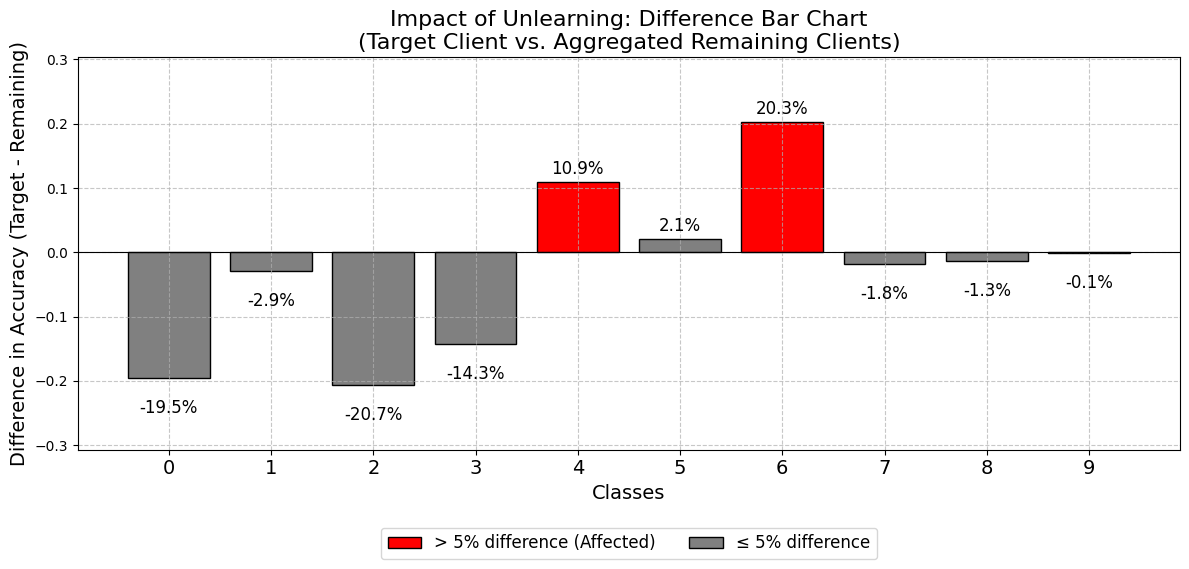

In [9]:
%load_ext autoreload
%autoreload 2

analytics = Analytics(cache)
analytics.plot_client_unlearning_impact_bar(0, testDataloader)


In [10]:
analytics.unlearned_model_vs_global_per_class_accuracy(testDataloader)

### Unlearned vs Global Model Per Class Accuracy ###
Unlearned Model Accuracy = 68.98%, Global Model Before Accuracy = 84.58%
Class 0: Global Model Before = 81.30%, After = 81.30%, Δ = 0.00%
Class 1: Global Model Before = 95.70%, After = 88.90%, Δ = -6.80%
Class 2: Global Model Before = 73.20%, After = 85.20%, Δ = 12.00%
Class 3: Global Model Before = 88.50%, After = 95.80%, Δ = 7.30%
Class 4: Global Model Before = 74.50%, After = 0.00%, Δ = -74.50%
Class 5: Global Model Before = 93.20%, After = 98.90%, Δ = 5.70%
Class 6: Global Model Before = 55.90%, After = 39.80%, Δ = -16.10%
Class 7: Global Model Before = 92.10%, After = 81.60%, Δ = -10.50%
Class 8: Global Model Before = 96.00%, After = 82.90%, Δ = -13.10%
Class 9: Global Model Before = 95.40%, After = 35.40%, Δ = -60.00%
######


In [9]:
analytics.global_before_vs_global_after_per_class_accuracy(testDataloader)


### Unlearned vs Global Model Per Class Accuracy ###
Global Model After Accuracy = 83.83%, Global Model Before Accuracy = 79.67%
Class 0: Global Model Before = 83.30%, After = 85.00%, Δ = 1.70%
Class 1: Global Model Before = 67.30%, After = 85.20%, Δ = 17.90%
Class 2: Global Model Before = 65.70%, After = 71.00%, Δ = 5.30%
Class 3: Global Model Before = 86.60%, After = 85.70%, Δ = -0.90%
Class 4: Global Model Before = 82.00%, After = 81.90%, Δ = -0.10%
Class 5: Global Model Before = 91.50%, After = 94.80%, Δ = 3.30%
Class 6: Global Model Before = 38.60%, After = 52.10%, Δ = 13.50%
Class 7: Global Model Before = 90.60%, After = 92.10%, Δ = 1.50%
Class 8: Global Model Before = 95.90%, After = 95.70%, Δ = -0.20%
Class 9: Global Model Before = 95.20%, After = 94.80%, Δ = -0.40%
######


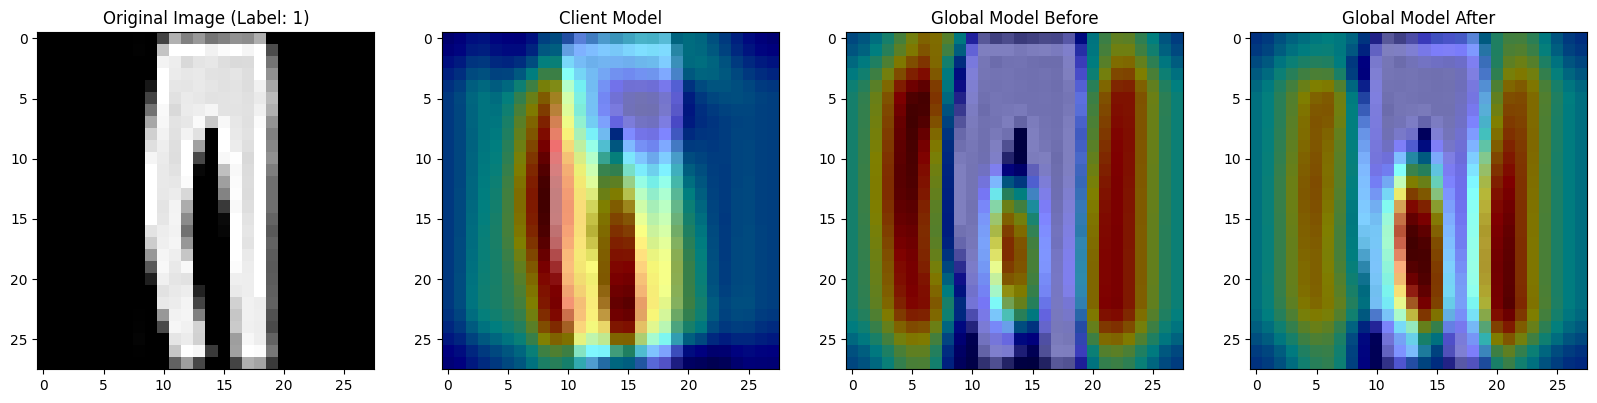

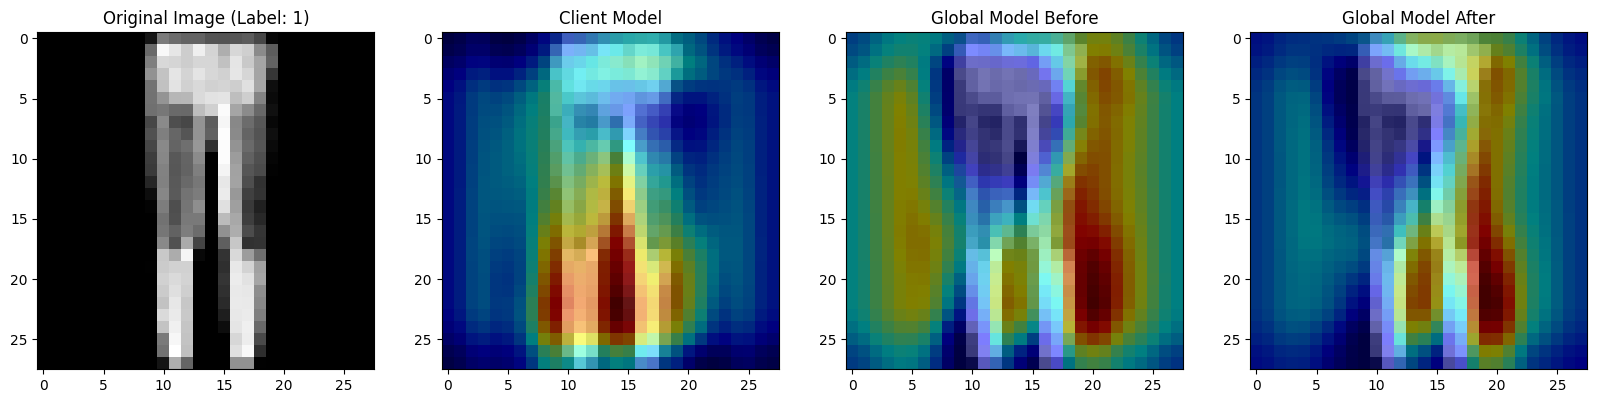

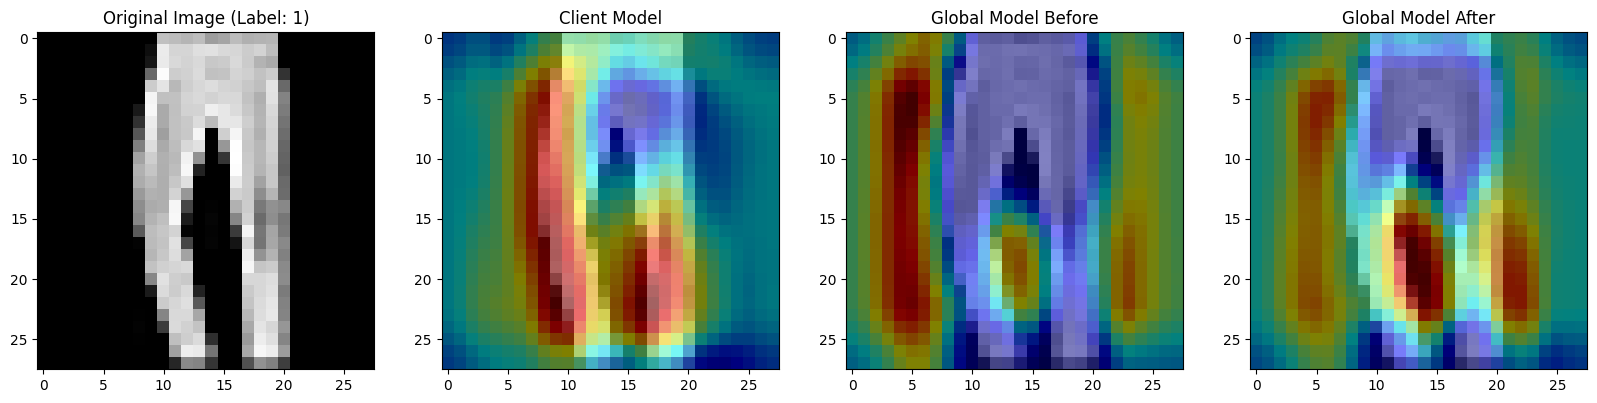

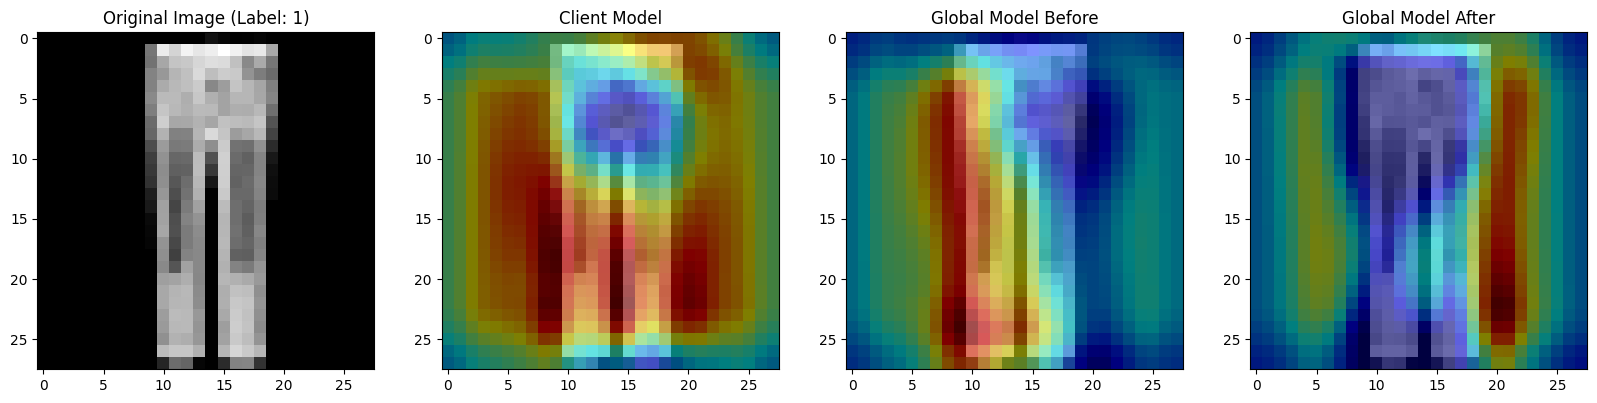

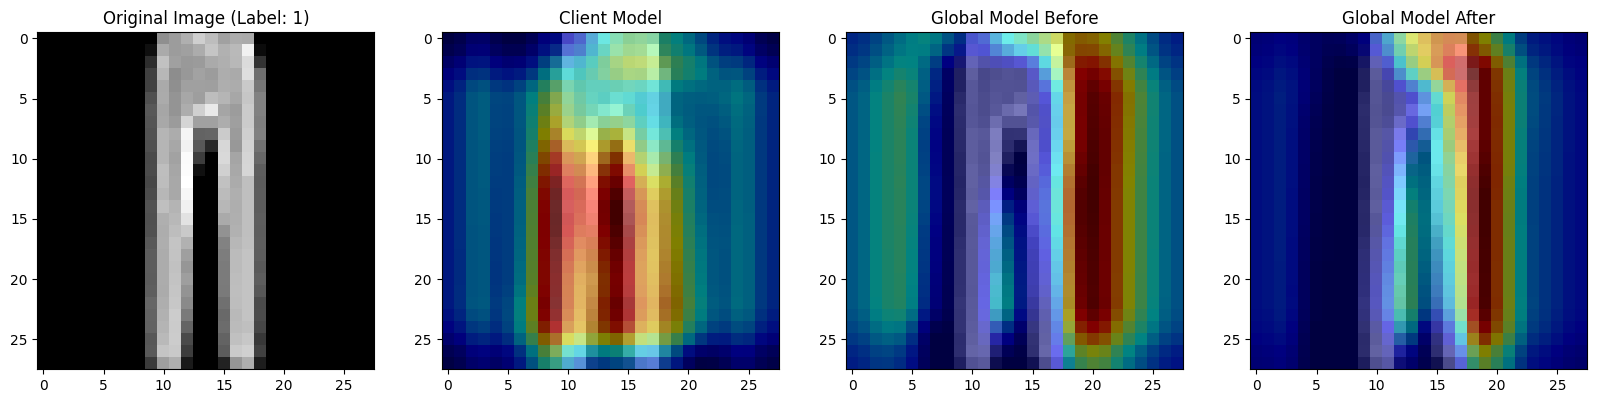

In [10]:
analytics.visualize_feature_comparison(client_idx=0, testDataloader=testDataloader, num_images_to_visualize=5, visualization_class=1)

In [11]:
analytics.display_classwise_metrics(0, testDataloader)


Class 0:
  Accuracy:
    Client Model:      ||||||||||||||||||||||||||---- (0.85)
    Global Before:     ||||||||||||||||||||||||||---- (0.83)
    Global After:      ||||||||||||||||||||||||||---- (0.85)
  Confidence:
    Client Model:      |||||||||||||||||||||||------- (0.76)
    Global Before:     ||||||||||||||||||||||-------- (0.70)
    Global After:      ||||||||||||||||||||||-------- (0.72)
---

Class 1:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||| (0.98)
    Global Before:     |||||||||||||||||||||--------- (0.67)
    Global After:      ||||||||||||||||||||||||||---- (0.85)
  Confidence:
    Client Model:      |||||||||||||||||||||||||||||| (0.96)
    Global Before:     ||||||||||||||||||------------ (0.58)
    Global After:      ||||||||||||||||||||||||------ (0.79)
---

Class 2:
  Accuracy:
    Client Model:      ||||||||||||||||||||||||------ (0.77)
    Global Before:     ||||||||||||||||||||---------- (0.66)
    Global After:      |||||||||||||||||||||

In [12]:
analytics.display_feature_summary(0, testDataloader)


Class 0:
Client Model 0:                  ||||||||||||||||||||||-------- (0.0119)
Global Model Before Unlearning:  ||||||||||||||||||||---------- (0.0106)
Global Model After Unlearning:   |||||||||||||||||||||--------- (0.0113)

Class 1:
Client Model 0:                  ||||||||||||||||||||||||||---- (0.0138)
Global Model Before Unlearning:  |||||||||||||||||------------- (0.0090)
Global Model After Unlearning:   |||||||||||||||||||----------- (0.0104)

Class 2:
Client Model 0:                  ||||||||||||||||||------------ (0.0096)
Global Model Before Unlearning:  |||||||||||||||||------------- (0.0091)
Global Model After Unlearning:   |||||||||||||||||||----------- (0.0103)

Class 3:
Client Model 0:                  ||||||||||||||||-------------- (0.0085)
Global Model Before Unlearning:  ||||||||||||||||-------------- (0.0086)
Global Model After Unlearning:   ||||||||||||||||||||---------- (0.0104)

Class 4:
Client Model 0:                  ||||||||||||||||||||||||||---- (0.0141)
G

In [13]:
analytics.display_client_contributions_to_calss_compared_to_others(0, testDataloader, num_classes=10)


Class 0:
  Client 0 Model Accuracy:          ||||||||||||||||||||||||||---- (0.85) with 1000 samples
  Remaining Clients Model Accuracy: |||||||||||||||||||||||||----- (0.83) with 1000 samples
  Global Model Accuracy:            ||||||||||||||||||||||||||---- (0.83) with 1000 samples

Class 1:
  Client 0 Model Accuracy:          |||||||||||||||||||||||||||||| (0.98) with 1000 samples
  Remaining Clients Model Accuracy: ||||||||||||||||-------------- (0.53) with 1000 samples
  Global Model Accuracy:            |||||||||||||||||||||--------- (0.67) with 1000 samples

Class 2:
  Client 0 Model Accuracy:          ||||||||||||||||||||||||------ (0.77) with 1000 samples
  Remaining Clients Model Accuracy: ||||||||||||||||||||---------- (0.65) with 1000 samples
  Global Model Accuracy:            ||||||||||||||||||||---------- (0.66) with 1000 samples

Class 3:
  Client 0 Model Accuracy:          ||||||||||||||||||||||||------ (0.77) with 1000 samples
  Remaining Clients Model Accuracy: ||||

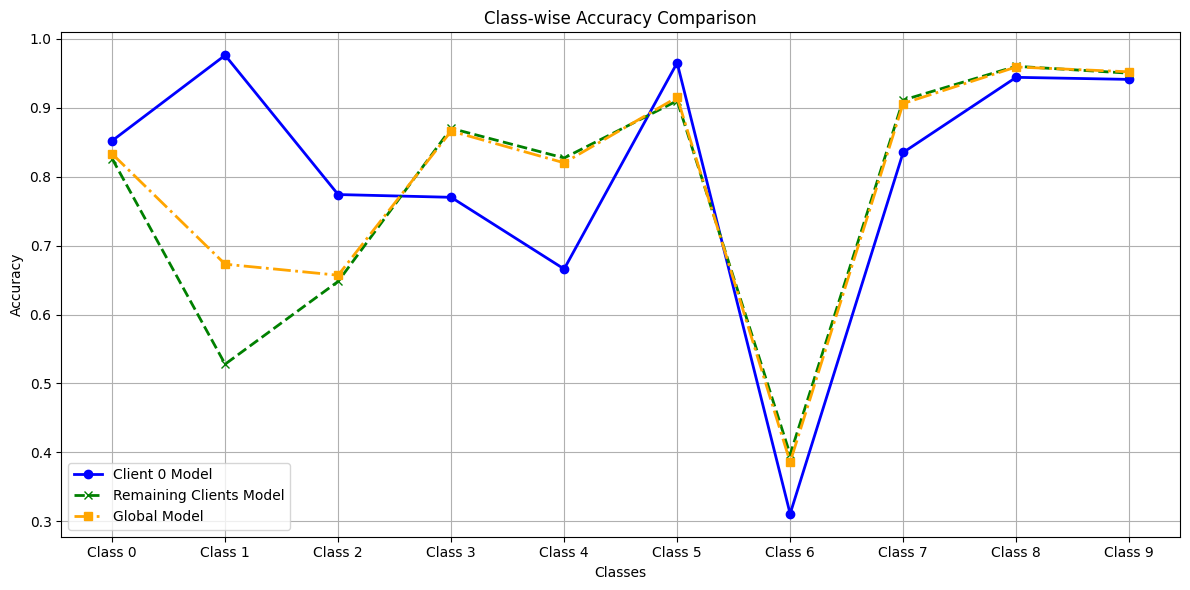

In [14]:
analytics.plot_client_contributions_to_calss_compared_to_others(0, testDataloader, num_classes=10)

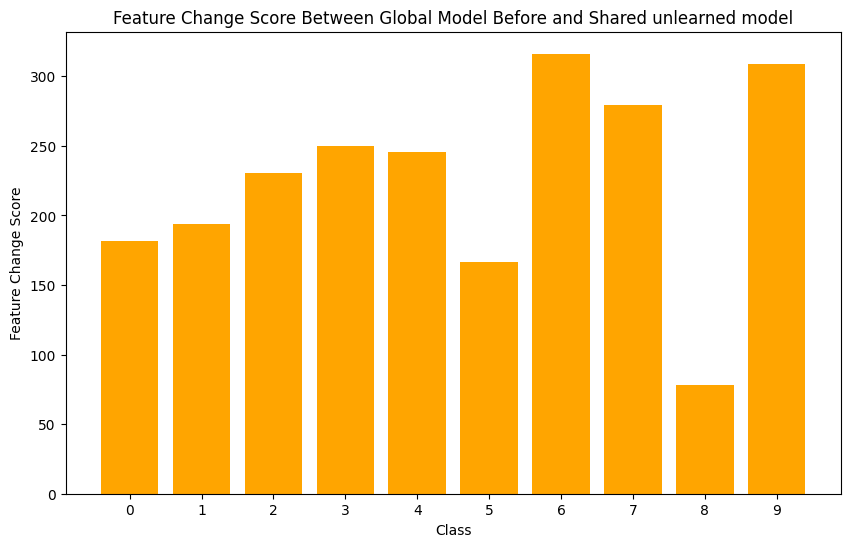

In [14]:
analytics.visualize_feature_change_class_wise_shared_unlearned_model(client_idx=0, testDataloader=testDataloader)

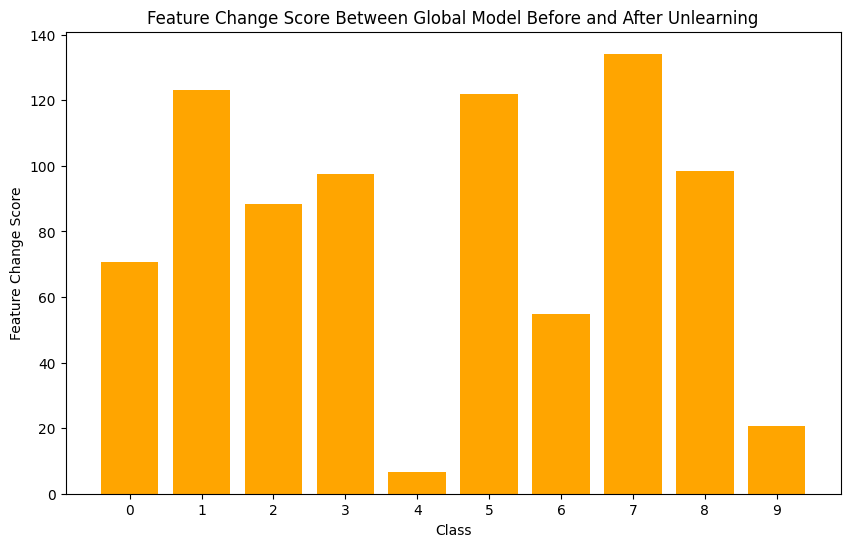

In [13]:
analytics.visualize_feature_change_class_wise(client_idx=0, testDataloader=testDataloader)

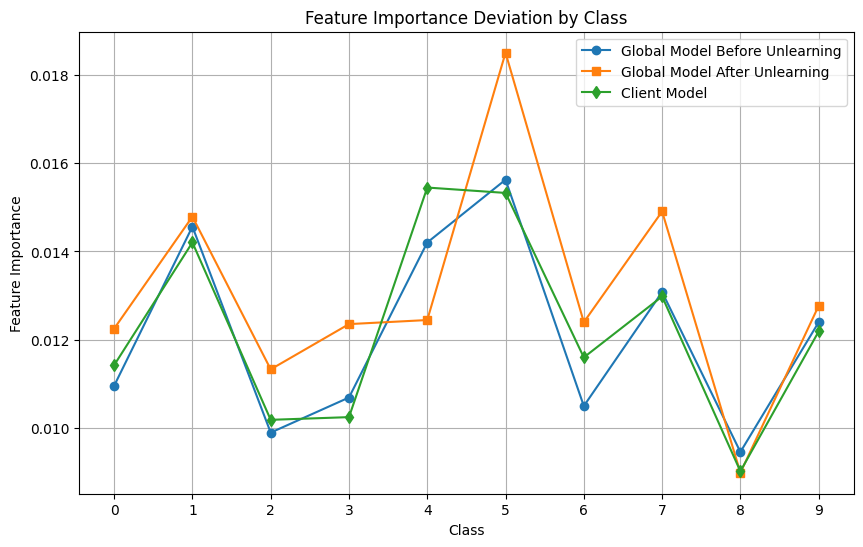

In [15]:
analytics.plot_mean_feature_deviation(client_idx=0, test_loader=testDataloader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


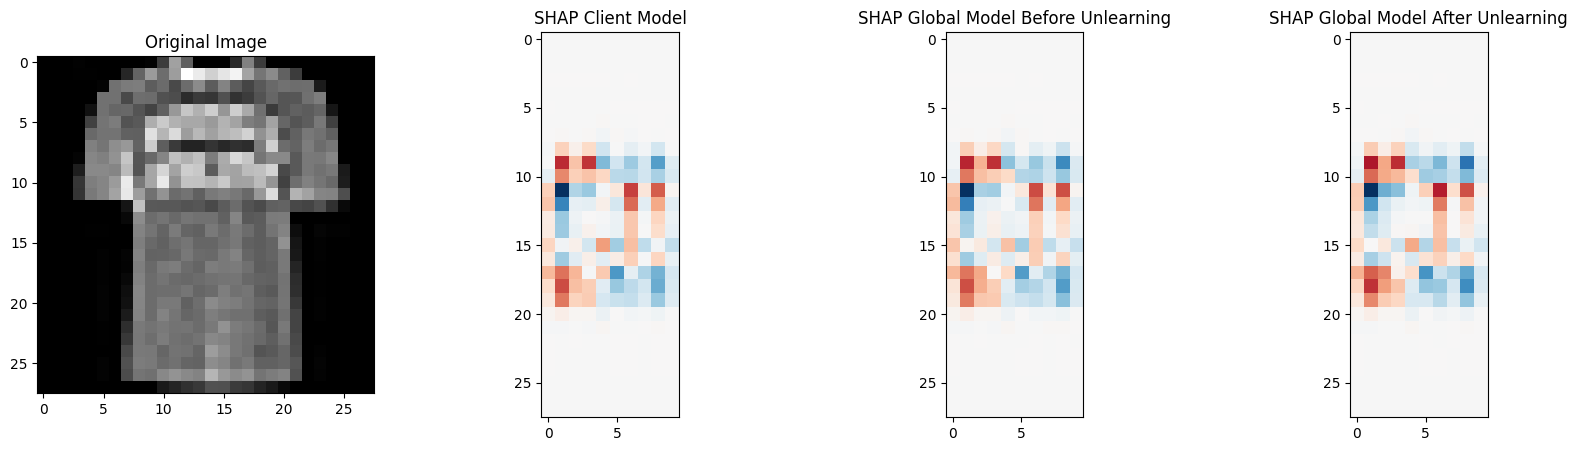

In [12]:
%load_ext autoreload
%autoreload 2

analytics = Analytics(cache)
analytics.plot_shap_comparison(0, testDataloader)

Global Model Before Unlearning Accuracy: 84.58%
Unlearned Model Accuracy: 84.13%
Unlearned Model Accuracy with FulDebug: 85.65%
Client Model Accuracy: 81.77%


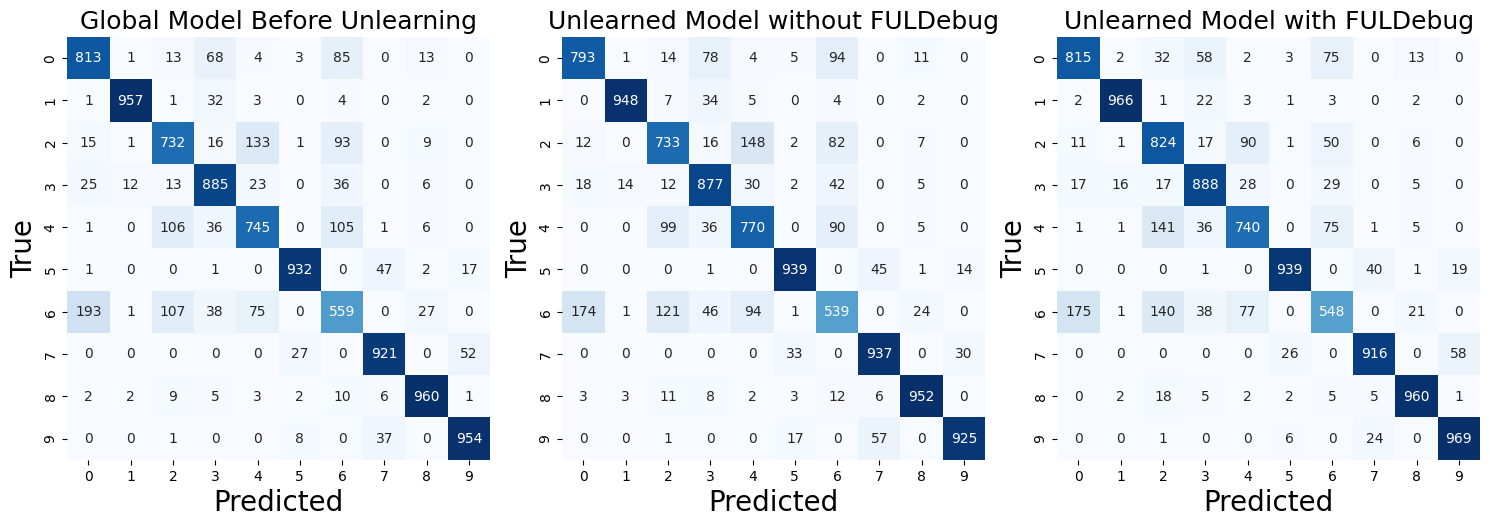

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assume these models are retrieved from your cache as in your snippet:
unlearned_model = cache.get('initial_model')
unlearned_model.load_state_dict(cache.get("unlearning_global_models"))
unlearned_model.eval()

unlearned_model_with_fuldebug = cache.get('initial_model')
unlearned_model_with_fuldebug.load_state_dict(cache.get("unlearning_global_models_with_FULDebug"))
unlearned_model_with_fuldebug.eval()

global_model_before = cache.get('initial_model')
global_model_before.load_state_dict(cache.get("global_models"))
global_model_before.eval()

client_model = cache.get('initial_model')
client_model.load_state_dict(cache.get("client_models")[0].state_dict())
client_model.eval()

# Prepare the test dataset (MNIST)
# transform = transforms.Compose([transforms.ToTensor()])
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = testDataloader

def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # If images have shape [N, 1, 1, 28, 28], squeeze the extra dimension.
            if images.dim() == 5 and images.size(1) == 1:
                images = images.squeeze(1)  # New shape: [N, 1, 28, 28]
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Evaluate each model on the test dataset
labels_global, preds_global = evaluate_model(global_model_before, test_loader, device)
labels_unlearned, preds_unlearned = evaluate_model(unlearned_model, test_loader, device)
labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug = evaluate_model(unlearned_model_with_fuldebug, test_loader, device)
labels_client, preds_client = evaluate_model(client_model, test_loader, device)

# Calculate confusion matrices and accuracies
cm_global = confusion_matrix(labels_global, preds_global)
cm_unlearned_without_fuldebug = confusion_matrix(labels_unlearned, preds_unlearned)
cm_unlearned_with_fuldebug = confusion_matrix(labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug)
cm_client = confusion_matrix(labels_client, preds_client)

acc_global = accuracy_score(labels_global, preds_global)
acc_unlearned = accuracy_score(labels_unlearned, preds_unlearned)
acc_unlearned_with_fuldebug = accuracy_score(labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug)
acc_client = accuracy_score(labels_client, preds_client)

print(f"Global Model Before Unlearning Accuracy: {acc_global*100:.2f}%")
print(f"Unlearned Model Accuracy: {acc_unlearned*100:.2f}%")
print(f"Unlearned Model Accuracy with FulDebug: {acc_unlearned_with_fuldebug*100:.2f}%")
print(f"Client Model Accuracy: {acc_client*100:.2f}%")

# Plot confusion matrices side by side in equal-size subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Global Model Before Unlearning
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues', ax=axes[0], square=True, cbar=False)
axes[0].set_title(f'Global Model Before Unlearning', fontsize=18)
axes[0].set_xlabel('Predicted', fontsize=20)
axes[0].set_ylabel('True', fontsize=20)

# Unlearned Model without FULDebug
sns.heatmap(cm_unlearned_without_fuldebug, annot=True, fmt='d', cmap='Blues', ax=axes[1], square=True, cbar=False)
axes[1].set_title(f'Unlearned Model without FULDebug', fontsize=18)
axes[1].set_xlabel('Predicted', fontsize=20)
axes[1].set_ylabel('True', fontsize=20)

# Unlearned Model with FULDebug
sns.heatmap(cm_unlearned_with_fuldebug, annot=True, fmt='d', cmap='Blues', ax=axes[2], square=True, cbar=False)
axes[2].set_title(f'Unlearned Model with FULDebug', fontsize=18)
axes[2].set_xlabel('Predicted', fontsize=20)
axes[2].set_ylabel('True', fontsize=20)

# Client Model
# sns.heatmap(cm_client, annot=True, fmt='d', cmap='Blues', ax=axes[3], square=True, cbar=False)
# axes[3].set_title(f'Unlearned Client Model', fontsize=18)
# axes[3].set_xlabel('Predicted', fontsize=20)
# axes[3].set_ylabel('True', fontsize=20)

plt.tight_layout()
plt.savefig('fmnist-10-ibmful')
plt.show()


In [20]:
import torch
import numpy as np
import shap
import matplotlib.pyplot as plt


# Assume these models are retrieved from your cache as in your snippet:
unlearned_model = cache.get('initial_model')
unlearned_model.load_state_dict(cache.get("unlearning_global_models"))
unlearned_model.eval()

unlearned_model_with_fuldebug = cache.get('initial_model')
unlearned_model_with_fuldebug.load_state_dict(cache.get("unlearning_global_models_with_FULDebug"))
unlearned_model_with_fuldebug.eval()

global_model_before = cache.get('initial_model')
global_model_before.load_state_dict(cache.get("global_models"))
global_model_before.eval()

client_model = cache.get('initial_model')
client_model.load_state_dict(cache.get("client_models")[0].state_dict())
client_model.eval()

num_samples=100
# Get a subset of test samples.
X_sample_list = []
for images, labels in testDataloader:
    X_sample_list.append(images)
    if sum([imgs.size(0) for imgs in X_sample_list]) >= num_samples:
        break
X_sample = torch.cat(X_sample_list, dim=0)[:num_samples].to(device)

# If needed, ensure that the images have correct shape.
# For MNIST, expect shape: [N, 1, H, W].
if X_sample.dim() == 3:
    X_sample = X_sample.unsqueeze(1)
elif X_sample.dim() == 4 and X_sample.size(1) != 1:
    # If channels-last, convert to channels-first.
    if X_sample.size(-1) == 1:
        X_sample = X_sample.permute(0, 3, 1, 2)

# Create SHAP DeepExplainers for each model.
# We use X_sample as the background (for simplicity; ideally, use a representative background set)
explainer_client = shap.DeepExplainer(client_model, X_sample)
explainer_global = shap.DeepExplainer(model_global, X_sample)
explainer_unlearned = shap.DeepExplainer(model_unlearned_no_debug, X_sample)

# Compute SHAP values for the test sample.
# For classification, shap_values is a list (one per output); we sum over outputs.
shap_vals_client = np.sum([np.abs(s) for s in explainer_client.shap_values(X_sample)], axis=0)
shap_vals_global = np.sum([np.abs(s) for s in explainer_global.shap_values(X_sample)], axis=0)
shap_vals_unlearned = np.sum([np.abs(s) for s in explainer_unlearned.shap_values(X_sample)], axis=0)

# Average SHAP values over the test samples.
avg_shap_client = np.mean(shap_vals_client, axis=0)  # shape: (channels, H, W)
avg_shap_global = np.mean(shap_vals_global, axis=0)
avg_shap_unlearned = np.mean(shap_vals_unlearned, axis=0)

# For MNIST, channels=1; flatten the HxW dimensions.
avg_shap_client_flat = avg_shap_client.flatten()
avg_shap_global_flat = avg_shap_global.flatten()
avg_shap_unlearned_flat = avg_shap_unlearned.flatten()

# Identify the top_k features (pixels) from the client model.
top_indices = np.argsort(avg_shap_client_flat)[-top_k:]

# Extract the corresponding SHAP values.
top_client = avg_shap_client_flat[top_indices]
top_global = avg_shap_global_flat[top_indices]
top_unlearned = avg_shap_unlearned_flat[top_indices]

# Plot a grouped bar chart comparing the average SHAP values for the top features.
indices = np.arange(top_k)
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(indices - width, top_client, width, label='Client Model', color='blue')
plt.bar(indices, top_global, width, label='Global Model', color='green')
plt.bar(indices + width, top_unlearned, width, label='Unlearned Model', color='red')

plt.xticks(indices, [f'Pixel {i}' for i in top_indices], rotation=45, fontsize=10)
plt.ylabel('Average |SHAP| Value', fontsize=12)
plt.title('Top Feature Contributions of Client Model and Changes After Unlearning', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [100, 1, 1, 28, 28]

In [30]:
import shap
import torch
import numpy as np
from torch.utils.data import DataLoader

# Assuming you have the following models and testDataloader
# client_model, model_global, model_unlearned_no_debug, testDataloader

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
client_model.to(device)
model_global.to(device)
model_unlearned_no_debug.to(device)

# Prepare test data
test_data = []
test_labels = []
for data, labels in testDataloader:
    test_data.append(data.numpy())
    test_labels.append(labels.numpy())
test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

# Convert numpy arrays to torch tensors and move to GPU
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).to(device)

# Reshape input tensor if necessary (e.g., for Conv2d models)
if len(test_data_tensor.shape) == 5:  # If shape is [batch_size, 1, 1, height, width]
    test_data_tensor = test_data_tensor.squeeze(1)  # Remove extra dimension

# Use a smaller subset of the data for SHAP computation
background_data = test_data_tensor[:50]  # Background dataset for SHAP
test_subset = test_data_tensor[:100]  # Test subset for SHAP computation

# Initialize SHAP explainers for each model
explainer_client = shap.GradientExplainer(client_model, background_data)
explainer_global = shap.GradientExplainer(model_global, background_data)
explainer_unlearned = shap.GradientExplainer(model_unlearned_no_debug, background_data)

# Compute SHAP values in parallel
shap_values_client = explainer_client.shap_values(test_subset)
shap_values_global = explainer_global.shap_values(test_subset)
shap_values_unlearned = explainer_unlearned.shap_values(test_subset)

# Convert SHAP values and test data back to CPU for visualization
shap_values_client = [np.array(v).cpu().numpy() for v in shap_values_client]
shap_values_global = [np.array(v).cpu().numpy() for v in shap_values_global]
shap_values_unlearned = [np.array(v).cpu().numpy() for v in shap_values_unlearned]
test_subset = test_subset.cpu().numpy()

# Visualize feature importance for each model
feature_names = testDataloader.dataset.feature_names if hasattr(testDataloader.dataset, 'feature_names') else None

# Client Model Feature Importance
shap.summary_plot(shap_values_client, test_subset, feature_names=feature_names, title="Client Model Feature Importance")

# Global Model Feature Importance
shap.summary_plot(shap_values_global, test_subset, feature_names=feature_names, title="Global Model Feature Importance")

# Unlearned Model Feature Importance
shap.summary_plot(shap_values_unlearned, test_subset, feature_names=feature_names, title="Unlearned Model Feature Importance")

# Compare feature contributions between models
# Example: Compare Client Model vs Global Model
shap.dependence_plot(0, shap_values_client[0], test_subset, feature_names=feature_names, title="Client Model Dependence Plot")
shap.dependence_plot(0, shap_values_global[0], test_subset, feature_names=feature_names, title="Global Model Dependence Plot")

# Compare Unlearned Model vs Global Model
shap.dependence_plot(0, shap_values_unlearned[0], test_subset, feature_names=feature_names, title="Unlearned Model Dependence Plot")
shap.dependence_plot(0, shap_values_global[0], test_subset, feature_names=feature_names, title="Global Model Dependence Plot")

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [33]:
import shap
import torch
import numpy as np

def analyze_feature_importance_with_shap(client_model, global_model, model_unlearned_no_debug, testDataloader, device):
    """
    Analyzes feature importance using SHAP, comparing client model, global model, and unlearned model.

    Args:
        client_model (torch.nn.Module): The client model.
        global_model (torch.nn.Module): The global model.
        model_unlearned_no_debug (torch.nn.Module): The unlearned model.
        testDataloader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to run the models on.

    Returns:
        tuple: A tuple containing:
            - shap_values_client (numpy.ndarray): SHAP values for the client model.
            - shap_values_global (numpy.ndarray): SHAP values for the global model.
            - shap_values_unlearned (numpy.ndarray): SHAP values for the unlearned model.
            - X_test (numpy.ndarray): The input data used for SHAP analysis.
    """
    client_model.to(device)
    global_model.to(device)
    model_unlearned_no_debug.to(device)

    client_model.eval()
    global_model.eval()
    model_unlearned_no_debug.eval()

    X_test = []
    for batch_x, _ in testDataloader:
        X_test.append(batch_x.cpu().numpy())
    X_test = np.concatenate(X_test, axis=0)

    # Remove the extra dimension
    X_test = np.squeeze(X_test, axis=1) # Remove the dimension at index 1.

    def client_predict(x):
        x = torch.from_numpy(x).to(device).float()
        # Ensure the extra dimension is also removed in the prediction function.
        x = torch.squeeze(x, dim=1)
        with torch.no_grad():
            return client_model(x).cpu().numpy()

    def global_predict(x):
        x = torch.from_numpy(x).to(device).float()
        x = torch.squeeze(x, dim=1)
        with torch.no_grad():
            return global_model(x).cpu().numpy()

    def unlearned_predict(x):
        x = torch.from_numpy(x).to(device).float()
        x = torch.squeeze(x, dim=1)
        with torch.no_grad():
            return model_unlearned_no_debug(x).cpu().numpy()

    # Use a subset for faster SHAP calculation (optional, but recommended for large datasets)
    subset_size = min(100, len(X_test)) #Adjust the subset size as needed.
    X_subset = shap.utils.sample(X_test, subset_size)

    explainer_client = shap.KernelExplainer(client_predict, X_subset)
    explainer_global = shap.KernelExplainer(global_predict, X_subset)
    explainer_unlearned = shap.KernelExplainer(unlearned_predict, X_subset)

    shap_values_client = explainer_client.shap_values(X_test)
    shap_values_global = explainer_global.shap_values(X_test)
    shap_values_unlearned = explainer_unlearned.shap_values(X_test)

    return shap_values_client, shap_values_global, shap_values_unlearned, X_test



# Assume these models are retrieved from your cache as in your snippet:
unlearned_model = cache.get('initial_model')
unlearned_model.load_state_dict(cache.get("unlearning_global_models"))
unlearned_model.eval()

unlearned_model_with_fuldebug = cache.get('initial_model')
unlearned_model_with_fuldebug.load_state_dict(cache.get("unlearning_global_models_with_FULDebug"))
unlearned_model_with_fuldebug.eval()

global_model = cache.get('initial_model')
global_model.load_state_dict(cache.get("global_models"))
global_model.eval()

client_model = cache.get('initial_model')
client_model.load_state_dict(cache.get("client_models")[0].state_dict())
client_model.eval()

# Example usage (assuming you have your models, testDataloader, and device defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

shap_values_client, shap_values_global, shap_values_unlearned, X_test = analyze_feature_importance_with_shap(
    client_model, global_model, model_unlearned_no_debug, testDataloader, device
)

# Analyze the results
# Example: Calculate the mean absolute SHAP values for each feature
mean_shap_client = np.abs(shap_values_client[0]).mean(axis=0) # Assuming single output
mean_shap_global = np.abs(shap_values_global[0]).mean(axis=0)
mean_shap_unlearned = np.abs(shap_values_unlearned[0]).mean(axis=0)

# Example: Identify the most important features in the client model
top_k = 10  # Top k important features
top_client_features = np.argsort(mean_shap_client)[::-1][:top_k]

print("Top Client Features:", top_client_features)
print("Mean SHAP values for client model top features:", mean_shap_client[top_client_features])
print("Mean SHAP values for global model top features:", mean_shap_global[top_client_features])
print("Mean SHAP values for unlearned model top features:", mean_shap_unlearned[top_client_features])

#Example: Compare the change in shap values.
shap_change = mean_shap_global[top_client_features] - mean_shap_unlearned[top_client_features]
print("Change in SHAP values (global - unlearned) for top client features:", shap_change)

# Example: Visualize SHAP values (requires matplotlib)
# shap.summary_plot(shap_values_client[0], X_test, feature_names=feature_names) #if you have feature names.

Provided model function fails when applied to the provided data set.


RuntimeError: Given groups=1, weight of size [32, 1, 5, 5], expected input[1, 100, 28, 28] to have 1 channels, but got 100 channels instead

100%|██████████| 50/50 [09:32<00:00, 11.46s/it]


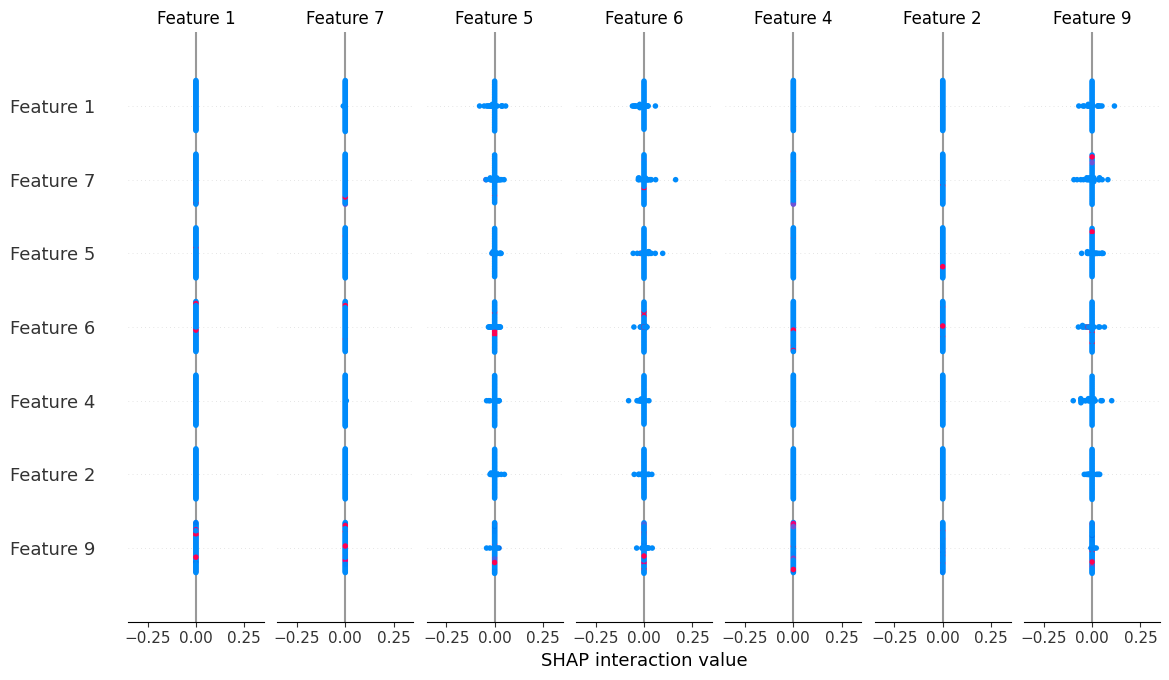

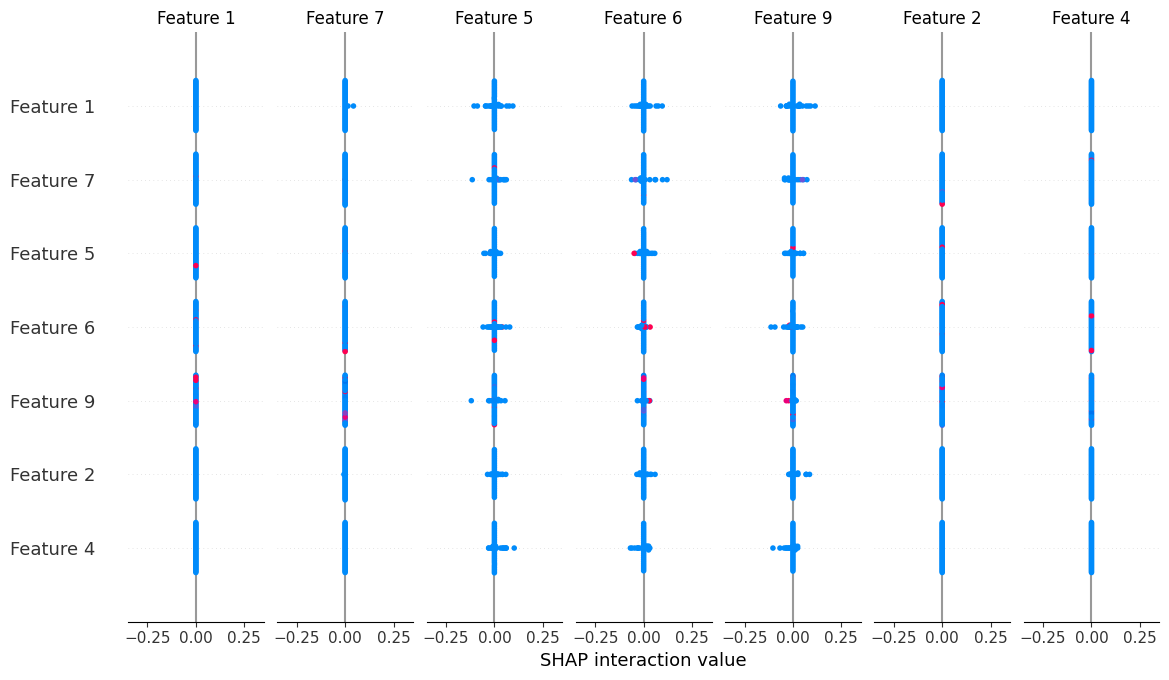

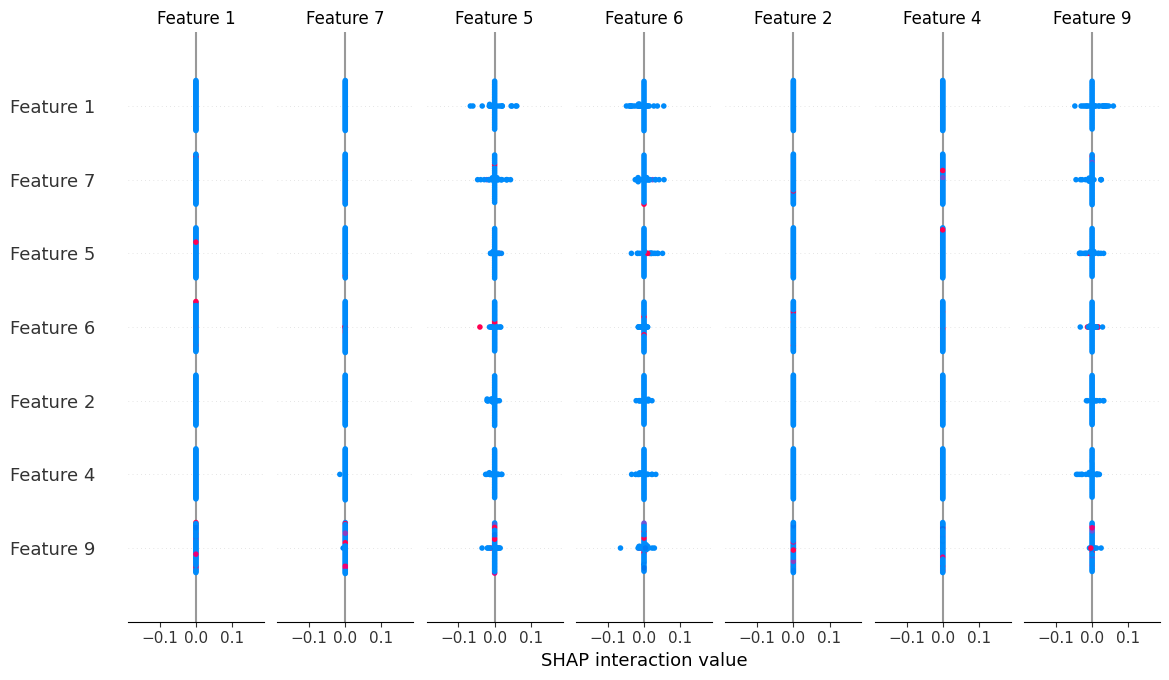

In [40]:
import shap
import torch
import numpy as np
from torch.utils.data import DataLoader

# Assuming you have the following models and testDataloader
# client_model, model_global, model_unlearned_no_debug, testDataloader

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
client_model.to(device)
model_global.to(device)
model_unlearned_no_debug.to(device)

# Prepare test data
test_data = []
test_labels = []
for data, labels in testDataloader:
    test_data.append(data.numpy())
    test_labels.append(labels.numpy())
test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

# Convert numpy arrays to torch tensors and move to GPU
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).to(device)

# Reshape input tensor if necessary (e.g., for Conv2d models)
if len(test_data_tensor.shape) == 5:  # If shape is [batch_size, 1, 1, height, width]
    test_data_tensor = test_data_tensor.squeeze(1)  # Remove extra dimension

# Flatten the data to 2D for SHAP
original_shape = test_data_tensor.shape  # Save original shape (e.g., [batch_size, channels, height, width])
flattened_data = test_data_tensor.view(test_data_tensor.shape[0], -1)  # Shape: [batch_size, features]

# Use a smaller subset of the data for SHAP computation
background_data = flattened_data[:10].cpu().numpy()  # Small background dataset (2D array)
test_subset = flattened_data[:50].cpu().numpy()  # Small test subset (2D array)

# Define a wrapper function to reshape data and run the model
def model_wrapper(model, data):
    # Reshape data back to original shape (e.g., [batch_size, channels, height, width])
    data_reshaped = data.reshape(-1, *original_shape[1:])
    data_tensor = torch.tensor(data_reshaped, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(data_tensor)
    return output.cpu().numpy()

# Initialize SHAP explainers for each model
explainer_client = shap.KernelExplainer(lambda x: model_wrapper(client_model, x), background_data)
explainer_global = shap.KernelExplainer(lambda x: model_wrapper(model_global, x), background_data)
explainer_unlearned = shap.KernelExplainer(lambda x: model_wrapper(model_unlearned_no_debug, x), background_data)

# Compute SHAP values in parallel
shap_values_client = explainer_client.shap_values(test_subset, n_jobs=4)
shap_values_global = explainer_global.shap_values(test_subset, n_jobs=4)
shap_values_unlearned = explainer_unlearned.shap_values(test_subset, n_jobs=4)

# Visualize feature importance for each model
feature_names = testDataloader.dataset.feature_names if hasattr(testDataloader.dataset, 'feature_names') else None

# Client Model Feature Importance
shap.summary_plot(shap_values_client, test_subset, feature_names=feature_names, title="Client Model Feature Importance")

# Global Model Feature Importance
shap.summary_plot(shap_values_global, test_subset, feature_names=feature_names, title="Global Model Feature Importance")

# Unlearned Model Feature Importance
shap.summary_plot(shap_values_unlearned, test_subset, feature_names=feature_names, title="Unlearned Model Feature Importance")